In [1]:
!pip install torch torchvision matplotlib

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device", device)

batch_size = 128
image_size = 28
channels = 1
latent_dim = 100
epochs = 10
lr = 0.0002

Using device cuda


In [4]:
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=transform
)

dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True
)

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 480kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.52MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.95MB/s]


In [5]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        self.net = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 256, 7, 1, 0, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.net(x)

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.net = nn.Sequential(
            nn.Conv2d(channels, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Flatten(),
            nn.Linear(128 * 7 * 7, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

In [7]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

criterion = nn.BCELoss()

optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

Epoch 0 D Loss 0.0006447509513236582 G Loss 8.010661125183105


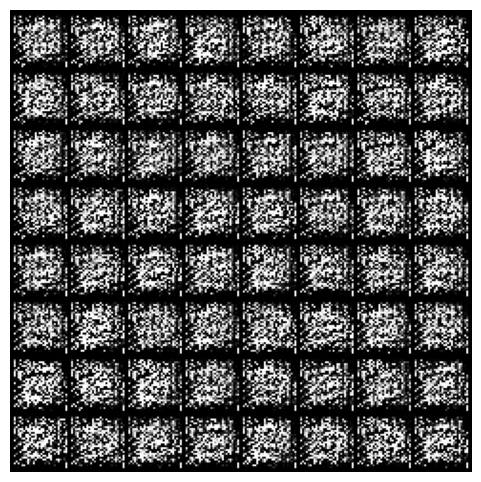

Epoch 1 D Loss 0.8207452893257141 G Loss 1.7532081604003906


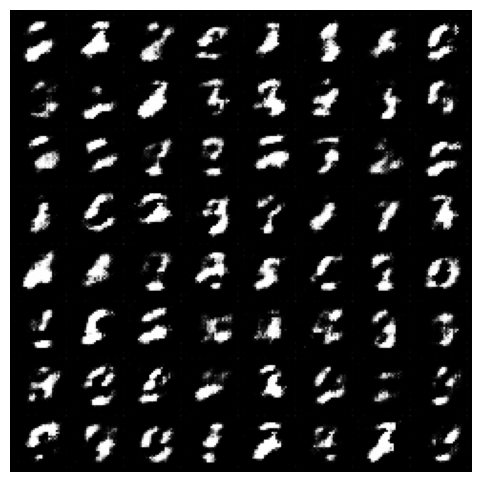

Epoch 2 D Loss 0.8538516759872437 G Loss 1.7732895612716675


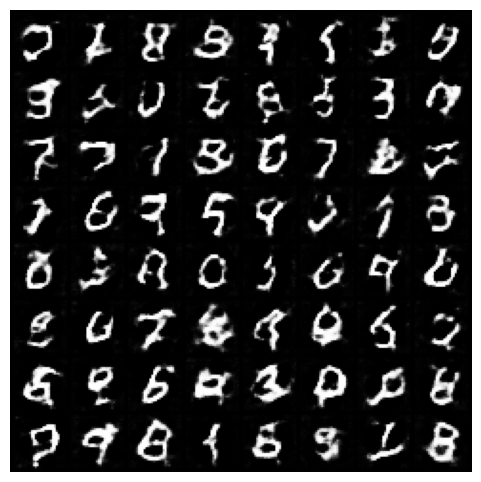

Epoch 3 D Loss 0.7025423049926758 G Loss 2.2182512283325195


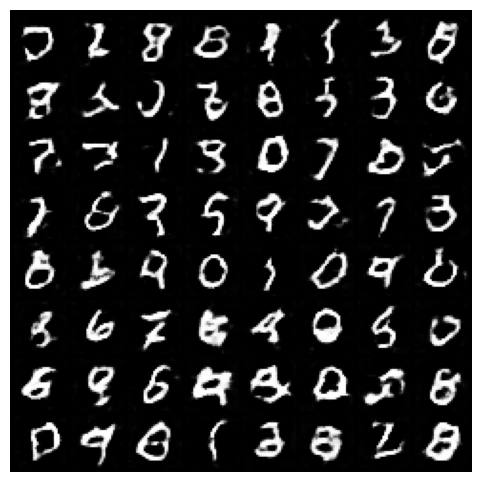

Epoch 4 D Loss 0.6561187505722046 G Loss 1.933504343032837


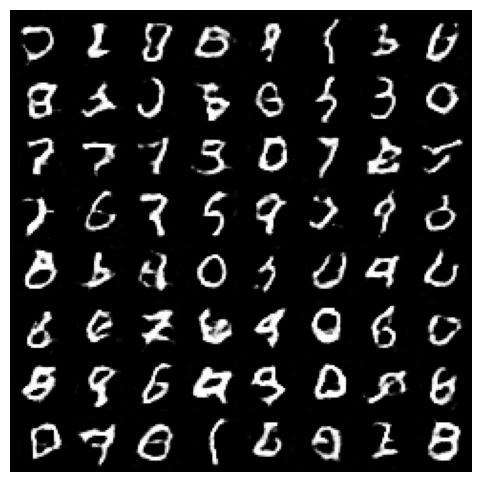

Epoch 5 D Loss 0.6804535388946533 G Loss 1.9411811828613281


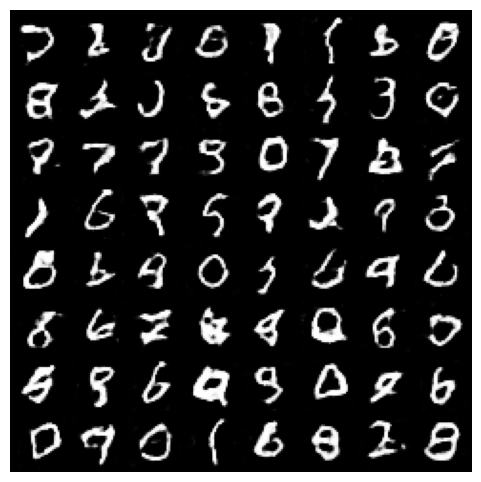

Epoch 6 D Loss 0.6805559396743774 G Loss 1.5872300863265991


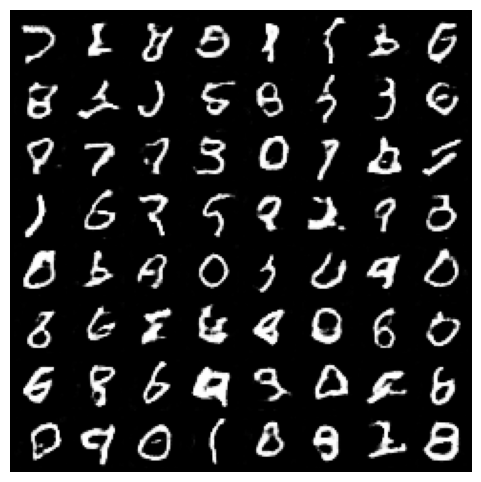

Epoch 7 D Loss 0.6470357775688171 G Loss 1.4108731746673584


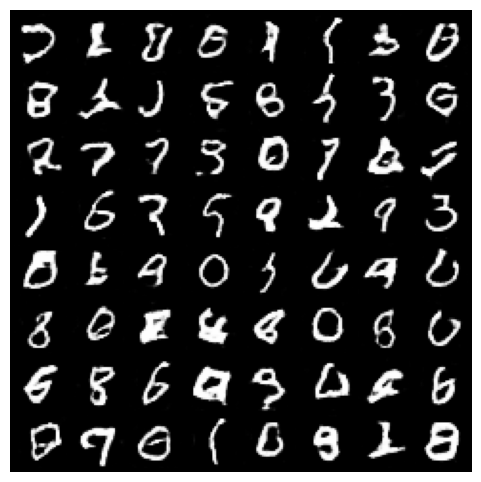

Epoch 8 D Loss 0.6701580286026001 G Loss 1.5446970462799072


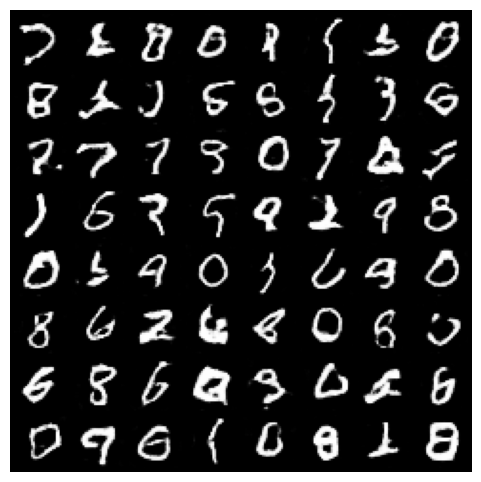

Epoch 9 D Loss 0.7668706178665161 G Loss 2.396406650543213


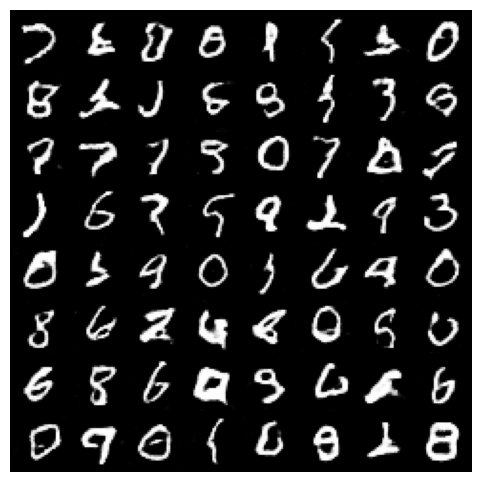

In [8]:
fixed_noise = torch.randn(64, latent_dim, 1, 1, device=device)

for epoch in range(epochs):
    for real_images, _ in dataloader:
        real_images = real_images.to(device)
        batch_size = real_images.size(0)

        real_labels = torch.ones(batch_size, 1, device=device)
        fake_labels = torch.zeros(batch_size, 1, device=device)

        # Train Discriminator
        optimizer_D.zero_grad()

        real_output = discriminator(real_images)
        d_loss_real = criterion(real_output, real_labels)

        noise = torch.randn(batch_size, latent_dim, 1, 1, device=device)
        fake_images = generator(noise)
        fake_output = discriminator(fake_images.detach())
        d_loss_fake = criterion(fake_output, fake_labels)

        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()

        fake_output = discriminator(fake_images)
        g_loss = criterion(fake_output, real_labels)
        g_loss.backward()
        optimizer_G.step()

    print(
        "Epoch", epoch,
        "D Loss", d_loss.item(),
        "G Loss", g_loss.item()
    )

    # Generate samples every epoch
    with torch.no_grad():
        fake_samples = generator(fixed_noise).cpu()
        grid = make_grid(fake_samples, nrow=8, normalize=True)
        plt.figure(figsize=(6,6))
        plt.imshow(grid.permute(1, 2, 0))
        plt.axis("off")
        plt.show()